# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [614]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [615]:
# Завантаження даних
df = pd.read_csv('/content/tweet_sentiment_train.csv.zip')

df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [616]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


Розмір нашого датафрейму: 27481 рядків та 4 стовпц, що містять дані типу object.


In [617]:
df.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


У стовпцях text і selected_text по 1 пропущеному значенню.

In [618]:
df = df.dropna()

In [619]:
df.shape

(27480, 4)

Після видалення пропущених значень розмір датафрейму 27480 рядки та 4 стовбці.

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [620]:
# Додаємо колонку з довжиною повного тексту
df['text_length'] = df['text'].apply(len)
# Додаємо колонку з довжиною вибраного тексту
df['select_text_length'] = df['selected_text'].apply(len)

In [621]:
# Аналіз кількості класів
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64


In [622]:
sentiment_percent = df['sentiment'].value_counts(normalize=True) * 100
print(sentiment_percent)

sentiment
neutral     40.454876
positive    31.229985
negative    28.315138
Name: proportion, dtype: float64


Найпоширеніший клас neutral, займає найбільшу частину вибірки і становить 40.5%.

positive та negative мають по 31.2% і 28.3% відповідно.

Спостерігається невеликий дисбаланс класів — нейтральних прикладів більше, ніж позитивних і негативних. Це може дещо зменшувати здатність моделі правильно вгадувати позитивні чи негативні настрої.

<ipython-input-623-3a167b5f203b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=axes[0], palette='Set2')


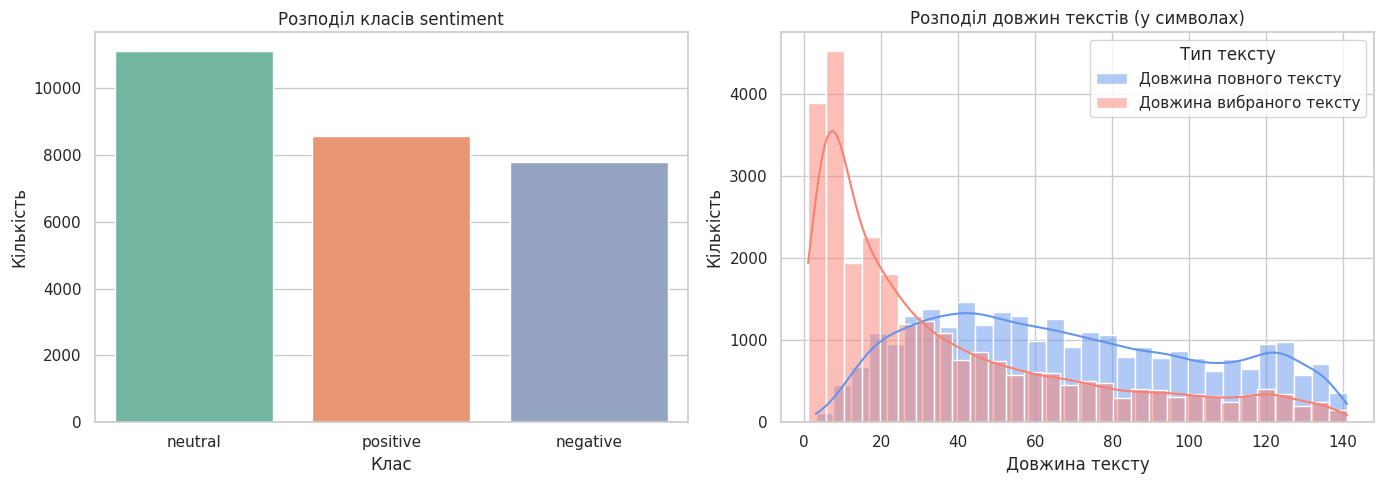

In [623]:
# Візуалізація

# Створення графіків
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Графік 1: Розподіл sentiment
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=axes[0], palette='Set2')
axes[0].set_title("Розподіл класів sentiment")
axes[0].set_xlabel("Клас")
axes[0].set_ylabel("Кількість")

# Графік 2: Розподіл довжин текстів
sns.histplot(df['text_length'], bins=30, kde=True, ax=axes[1], color='cornflowerblue', label='Довжина повного тексту')
sns.histplot(df['select_text_length'], bins=30, kde=True, ax=axes[1], color='salmon', label='Довжина вибраного тексту')
axes[1].set_title("Розподіл довжин текстів (у символах)")
axes[1].set_xlabel("Довжина тексту")
axes[1].set_ylabel("Кількість")

axes[1].legend(title="Тип тексту")

plt.tight_layout()
plt.show()


На графіку тепер візуально бачимо, що neutral — найпоширеніший клас. Це може означати, що більшість текстів не мають вираженого емоційного забарвлення.

Під час побудови моделі може знадобитися вирівнювання ваг (class weights) та використання замість стандартної метрики accuracy метрик, більш чутливих до дисбалансу, таких як f1-score, precision, recall.

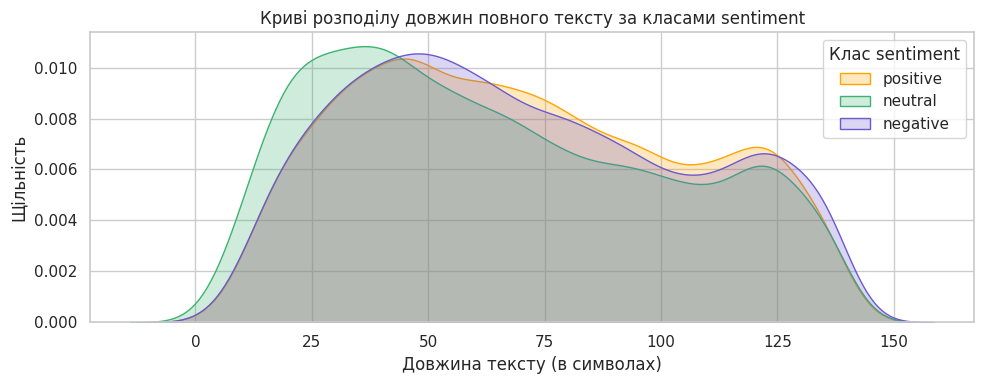

In [624]:
# Поглянемо на візуалізацію розподілу довжини тексту за класами

# Кольори для класів
colors = {
    'positive': 'orange',
    'neutral': 'mediumseagreen',
    'negative': 'slateblue'
}

plt.figure(figsize=(10, 4))

# Побудова KDE-графіків
for sentiment, color in colors.items():
    sns.kdeplot(
        data=df[df['sentiment'] == sentiment]['text_length'],
        label=sentiment,
        color=color,
        fill=True,
        linewidth=1
    )

plt.title("Криві розподілу довжин повного тексту за класами sentiment")
plt.xlabel("Довжина тексту (в символах)")
plt.ylabel("Щільність")
plt.legend(title="Клас sentiment")
plt.tight_layout()
plt.show()


Форма кривих схожа, але є відмінності в положенні максимумів і «хвостах».

Якщо подивитись на піки кривих (найвища точка щільності):

Нейтральний клас (зелена крива) має пік приблизно на 35–40 символах.

Позитивний клас (помаранчева) — біля 45.

Негативний клас (синя) має пік десь біля 50.

Усі криві мають основну масу розподілу між 30 і приблизно 80 символами — далі вони вже згасають.

Нейтральні твіти трохи коротші, це може свідчити, що користувачі часто пишуть короткі, лаконічні повідомлення без емоційного забарвлення.

Позитивні й негативні твіти довші.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [625]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
import re
from collections import  Counter
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [626]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [627]:
corpus = []
for x in df['text'].str.split():
    corpus.extend(x)

In [628]:
len(corpus)

354571

Ми створили один великий список усіх слів із усіх текстів з нашої колонки text.У нас вийшло 354 571 слів у загальному корпусі.

In [629]:
print(corpus[0:20])

['I`d', 'have', 'responded,', 'if', 'I', 'were', 'going', 'Sooo', 'SAD', 'I', 'will', 'miss', 'you', 'here', 'in', 'San', 'Diego!!!', 'my', 'boss', 'is']


In [630]:
counter=Counter(corpus)
most=counter.most_common()
most[0:20]

[('to', 9809),
 ('I', 8802),
 ('the', 8388),
 ('a', 6501),
 ('my', 4932),
 ('and', 4677),
 ('i', 4263),
 ('you', 3808),
 ('is', 3670),
 ('for', 3575),
 ('in', 3554),
 ('of', 3091),
 ('it', 3024),
 ('on', 2623),
 ('have', 2377),
 ('that', 2150),
 ('me', 2140),
 ('so', 2134),
 ('with', 2011),
 ('be', 1923)]

Ми порахували частоти слів у своєму корпусі і вивели найпопулярніші 20 слів.

In [631]:
# Чи є числа
df['has_numbers'] = df['text'].str.contains(r'\d')

# Чи є хештеги
df['has_hashtags'] = df['text'].str.contains(r'#\w+')

# Чи є @
df['has_mentions'] = df['text'].str.contains(r'@\w+')

# Чи є посилання
df['has_links'] = df['text'].str.contains(r'http\S+')

# Кількість таких твітів
df[['has_numbers', 'has_hashtags', 'has_mentions', 'has_links']].sum()


,0
has_numbers,4687
has_hashtags,523
has_mentions,74
has_links,1223


Ми перевірили кожен твіт на наявність:

чисел, хештегів, mentions, посилань

Та порахували скільки твітів містять кожен із цих елементів.

Числа (has_numbers)	4687 твітів містять числа
Хештеги (has_hashtags)	523 твітів містять хештеги
Згадки (has_mentions)	74 твіти містять згадки інших
Посилання (has_links)	1223 твіти містять посилання


In [632]:
df[df['has_numbers']][['text']].head(3)

,text
6,2am feedings for the baby are fun when he is a...
14,test test from the LG enV2
17,i`ve been sick for the past few days and thus...


In [633]:
df[df['has_hashtags'] & df['has_mentions']][['text']]

,text
4538,@_refugee_ /me gets 'Your video will start in ...
10983,"@_dritan Dam you, I want an #android, stupid o..."


In [634]:
import re
import string
import html
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

In [635]:
import nltk
nltk.download('punkt')         # для word_tokenize
nltk.download('stopwords')     # для стоп-слів

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [636]:
stop_words = set(stopwords.words('english'))
stop_words.discard("not")

stemmer = SnowballStemmer("english")

In [637]:
# Створимо функцію для попередньої обробки тексту

def custom_preprocessor(text):

    # Видалення посилань, mentions
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)

    # Видалення чисел та пунктуації
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Нижній регістр
    text = text.lower()

    # Токенізація
    tokens = word_tokenize(text)

    # Стоп-слова + стемінг
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

Ми створили функцію custom_preprocessor(text), яка:

Видаляє посилання та mentions.

Видаляє числа і пунктуацію.

Перетворює текст на нижній регістр.

Токенізує текст (розділяє на окремі слова).

Видаляє стоп-слова та застосовує стемінг до слів (скорочення до коренів).

При цьому ми залишили хештеги, оскільки вони можуть бути важливими для аналізу.

Ми видаляємо лише знак #, а сам хештег залишаємо.

In [638]:
print(custom_preprocessor("I can't wait; I'm so happy @you123!!! #fun http://link.com"))

cant wait im happi fun


In [639]:
sample_random = df['text'].sample(n=3, random_state=42)

for txt in sample_random:
    print("Оригінальний текст:", txt)
    print("Очищений текст:", custom_preprocessor(txt))
    print("---")

Оригінальний текст:  Enjoy! Family trumps everything
Очищений текст: enjoy famili trump everyth
---
Оригінальний текст:  --of them kinda turns me off of it all.  And then I buy more of them and dig a deeper hole, etc. ;;
Очищений текст: kinda turn buy dig deeper hole etc
---
Оригінальний текст: Clive it`s my birthday pat me  http://apps.facebook.com/dogbook/profile/view/6386106
Очищений текст: clive birthday pat
---


In [640]:
# Застосування до нашого тексту
df['text_clean'] = df['text'].apply(custom_preprocessor)

In [641]:
corpus_clean = []
for x in df['text_clean'].str.split():
    corpus_clean.extend(x)


In [642]:
len(corpus_clean)

199872

Результати:

199872 — це загальна кількість слів (токенів) у нашому корпусі після видалення шуму (стоп‑слів, пунктуації, цифр, посилань і згадок).

Порівняно з 354 571 ми прибрали біля 40 % усіх токенів, залишивши лише інформаційно значущі слова.


In [643]:
from collections import Counter

all_words = ' '.join(df['text_clean']).split()
word_freq = Counter(all_words)
print(f"Усього унікальних слів: {len(word_freq)}")

Усього унікальних слів: 21636


У нас залишилося 21636 унікальних слів, на які будемо орієнтуватися при побудові фіч.

In [644]:
from collections import Counter

# Функція: топ-слова за класом
def top_words_by_sentiment(df, sentiment, n=25):
    text = ' '.join(df[df['sentiment'] == sentiment]['text_clean'])
    counter = Counter(text.split())
    return counter.most_common(n)

# Приклади
print("Negative:", top_words_by_sentiment(df, 'negative'))
print("Neutral:", top_words_by_sentiment(df, 'neutral'))
print("Positive:", top_words_by_sentiment(df, 'positive'))

Negative: [('im', 1227), ('not', 826), ('go', 735), ('miss', 660), ('get', 613), ('work', 493), ('like', 491), ('dont', 469), ('feel', 466), ('cant', 464), ('sad', 443), ('day', 416), ('got', 356), ('sorri', 342), ('realli', 339), ('today', 326), ('want', 323), ('bad', 312), ('hate', 311), ('one', 301), ('think', 281), ('know', 277), ('na', 274), ('time', 272), ('still', 243)]
Neutral: [('im', 1059), ('go', 1055), ('get', 820), ('not', 747), ('day', 659), ('work', 647), ('got', 539), ('dont', 491), ('like', 482), ('time', 468), ('lol', 456), ('want', 449), ('today', 443), ('one', 438), ('know', 428), ('back', 412), ('u', 385), ('see', 382), ('think', 356), ('cant', 346), ('home', 340), ('need', 326), ('new', 320), ('good', 310), ('watch', 305)]
Positive: [('day', 1339), ('love', 1141), ('good', 1056), ('happi', 852), ('thank', 815), ('im', 743), ('mother', 668), ('go', 573), ('hope', 519), ('great', 482), ('like', 481), ('get', 476), ('today', 346), ('got', 345), ('fun', 344), ('work',

In [645]:
# топ-слова для кожного класу
negative_words = top_words_by_sentiment(df, 'negative')
neutral_words = top_words_by_sentiment(df, 'neutral')
positive_words = top_words_by_sentiment(df, 'positive')

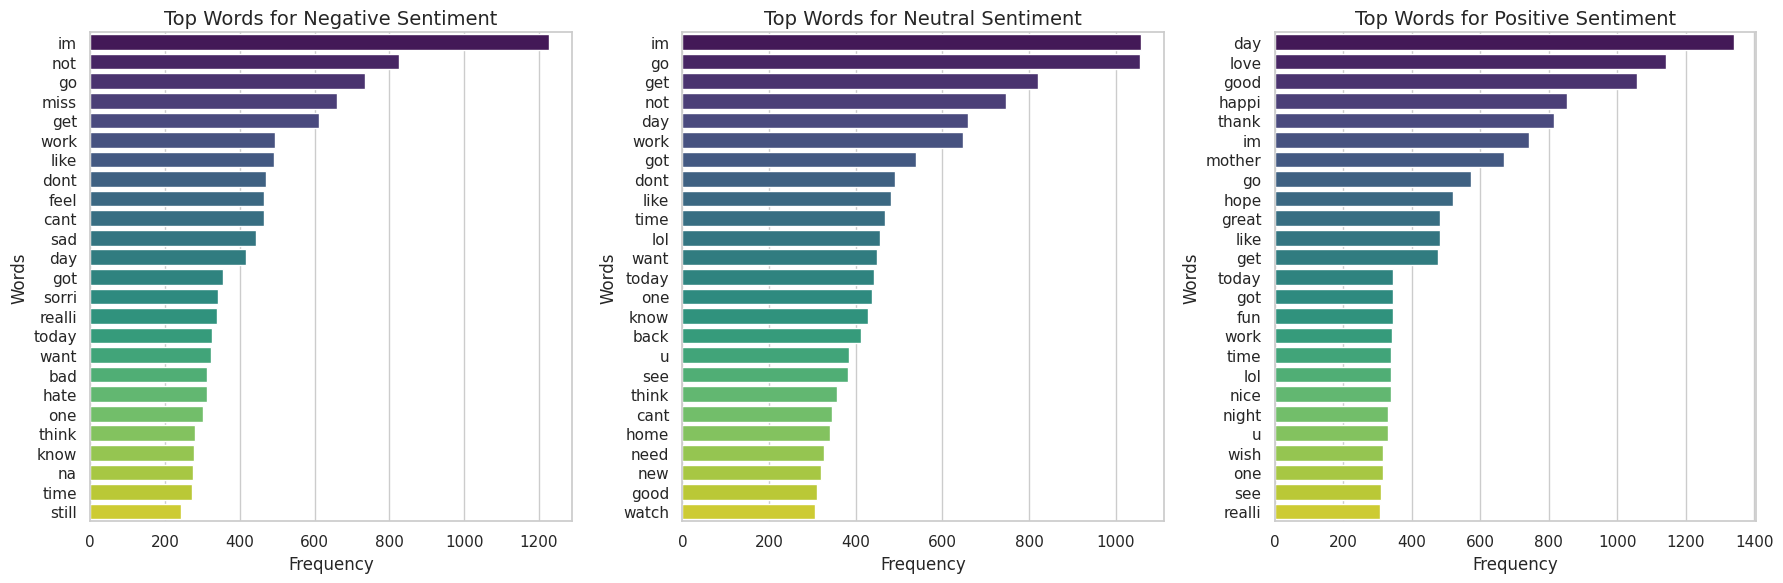

In [646]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Функція для побудови стовпчикової діаграми
def plot_bar_chart(ax, sentiment, top_words):
    words, counts = zip(*top_words)
    data = {'Words': words, 'Counts': counts}
    df_bar = pd.DataFrame(data)


    sns.barplot(x='Counts', y='Words', data=df_bar, palette="viridis", ax=ax, hue='Words')
    ax.set_title(f"Top Words for {sentiment} Sentiment", fontsize=14)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Створюємо стовпчикові діаграми для кожного класу
plot_bar_chart(axes[0], 'Negative', negative_words)
plot_bar_chart(axes[1], 'Neutral', neutral_words)
plot_bar_chart(axes[2], 'Positive', positive_words)


plt.tight_layout()
plt.show()


Висновки:
Клас Negative:

Найпоширеніші слова: "im", "not", "go", "miss", "get", "work", "like", "dont", "feel", "cant", "sad", "day", "got", "sorri", "realli" і т.д.

Очевидно, що слова, які часто зустрічаються, мають негативне забарвлення (наприклад: "sad", "miss", "hate", "dont").

Клас Neutral:

Найпоширеніші слова: "im", "go", "get", "not", "day", "work", "got", "dont", "like", "time", "lol", "want", "today", "one", "know".

В нейтральному класі більше слів, які не мають чітко вираженого емоційного забарвлення.

Клас Positive:

Найпоширеніші слова: "day", "love", "good", "happi", "thank", "im", "mother", "go", "hope", "great", "like".

Позитивний клас збагачений словами, що виражають позитивні емоції, наприклад: "love", "happi", "good", "thank".

In [647]:
from collections import Counter

# Рахуємо всі слова
all_words = ' '.join(df['text_clean']).split()
word_counts = Counter(all_words)

# Загальна кількість слів у корпусі
total_word_count = sum(word_counts.values())

# Топ-2000 слів
top_2000 = word_counts.most_common(2000)
top_2000_word_count = sum(freq for _, freq in top_2000)

# Покриття
coverage = (top_2000_word_count / total_word_count) * 100

print(f" Загальна кількість унікальних слів: {len(word_counts)}")
print(f" Топ-2000 слів покривають: {coverage:.2f}% усіх слів у корпусі")


 Загальна кількість унікальних слів: 21636
 Топ-2000 слів покривають: 81.63% усіх слів у корпусі


Як бачимо топ-2000 слів покривають 81.63% усіх слів у корпусі. Це означає, що найбільш поширені 2000 слів становлять 81.63% від загальної кількості всіх слів у нашому корпусі. Тобто 2000 найбільш частих слів вже забезпечують велику частину лексики в корпусі.

In [648]:
top_2000_words = [word for word, _ in top_2000]

In [649]:
# Подивимось що це за слова
top_2000_words

['im',
 'day',
 'go',
 'get',
 'not',
 'good',
 'work',
 'love',
 'like',
 'got',
 'dont',
 'today',
 'time',
 'one',
 'cant',
 'happi',
 'want',
 'know',
 'thank',
 'miss',
 'lol',
 'u',
 'realli',
 'back',
 'see',
 'think',
 'feel',
 'mother',
 'night',
 'hope',
 'make',
 'well',
 'new',
 'home',
 'look',
 'na',
 'need',
 'still',
 'oh',
 'much',
 'watch',
 'come',
 'great',
 'wish',
 'last',
 'morn',
 'haha',
 'twitter',
 'that',
 'sad',
 'week',
 'ill',
 'fun',
 'tomorrow',
 'would',
 'say',
 'bad',
 'thing',
 'tri',
 'follow',
 'wait',
 'sleep',
 'tonight',
 'sorri',
 'didnt',
 'right',
 'friend',
 'gon',
 'nice',
 'yeah',
 'better',
 'though',
 'way',
 'mom',
 'weekend',
 'take',
 'ive',
 'could',
 'even',
 'hate',
 'peopl',
 'start',
 'bed',
 'show',
 'hour',
 'next',
 'your',
 'play',
 'school',
 'guy',
 'awesom',
 'tweet',
 'movi',
 'best',
 'final',
 'year',
 'girl',
 'call',
 'long',
 'use',
 'littl',
 'hey',
 'soon',
 'never',
 'wont',
 'suck',
 'yes',
 'let',
 'sure',
 'li

В нашому списку найчастіше використовуваних в тексті слів є символ 'iï¿½m',
яким позначається помилка декодування, замінимо цей символ на порожнє значення за допомогою регулярного виразу
та додамо до нашої функції custom_preprocessor:

In [650]:
# Доповнена функція для обробки тексту

def custom_preprocessor(text):

    # Видалення посилань, mentions
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)

    # Видалення чисел та пунктуації
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'ï¿½', '', text)

    # Нижній регістр
    text = text.lower()

    # Токенізація
    tokens = word_tokenize(text)

    # Стоп-слова + стемінг
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [651]:
# Перевіряємо чи працює
print(custom_preprocessor("I can't wait; I'm so happy @you123!!! ï¿½ #fun http://link.com"))

cant wait im happi fun


In [652]:
vectorizer = CountVectorizer(
    preprocessor=custom_preprocessor,  # Очищення тексту
    vocabulary=top_2000_words        # Словник
)
X_bow = vectorizer.fit_transform(df['text_clean'])


In [653]:
X_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 153829 stored elements and shape (27480, 2000)>

In [654]:
# Перевіримо розмір матриці
print("Розмір матриці Bag of Words:", X_bow.shape)

Розмір матриці Bag of Words: (27480, 2000)


Після векторизації текстів за допомогою Bag of Words (BoW) з використанням CountVectorizer і словника з топ-2000 слів, ми отримали матрицю розміром 27480x2000:

27480 рядків (документів).

2000 стовпців, кожен із яких відповідає одному з топ-2000 слів у словнику.

### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [655]:
from sklearn.model_selection import train_test_split

# Розділяємо дані
X_train, X_test, y_train, y_test = train_test_split(
    df['text_clean'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment']
)

In [656]:
# Навчимо векторизатор тільки на тренувальних даних
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

In [657]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Перетворення міток у числа
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


In [658]:
print("Класи та їх відповідні числові значення:", le.classes_)

Класи та їх відповідні числові значення: ['negative' 'neutral' 'positive']


In [659]:
from sklearn.metrics import f1_score, classification_report

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight = 'balanced'),
        'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight = 'balanced'),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        macro_f1 = f1_score(y_test, y_pred, average='macro')
        print(f"F1 macro for {name}: {macro_f1:.4f}")
        print("Classification Report:")

        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print('---')


        results[name] = {'model': model, 'f1-score macro': macro_f1}

    # Знайдемо найкращу модель
    best_model_name = max(results, key=lambda name: results[name]['f1-score macro'])
    best_model = results[best_model_name]['model']

    print(f"\nНайкраща модель: {best_model_name} з F1 macro {results[best_model_name]['f1-score macro']:.4f}")
    return best_model

best_model_bow = train_and_evaluate_models(X_train_bow, X_test_bow, y_train_enc, y_test_enc)


F1 macro for Logistic Regression: 0.6955
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1556
           1       0.66      0.66      0.66      2223
           2       0.75      0.74      0.75      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.70      0.70      5496
weighted avg       0.69      0.69      0.69      5496

Confusion Matrix:
[[1076  395   85]
 [ 430 1464  329]
 [  98  353 1266]]
---
F1 macro for Decision Tree: 0.6327
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.62      0.61      1556
           1       0.62      0.59      0.61      2223
           2       0.69      0.69      0.69      1717

    accuracy                           0.63      5496
   macro avg       0.63      0.63      0.63      5496
weighted avg       0.63      0.63      0.63      5496

Confusion Matrix:
[[ 971  441  144]
 [ 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:44:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 macro for XGBoost: 0.6914
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.56      0.64      1556
           1       0.62      0.79      0.69      2223
           2       0.79      0.69      0.74      1717

    accuracy                           0.69      5496
   macro avg       0.72      0.68      0.69      5496
weighted avg       0.71      0.69      0.69      5496

Confusion Matrix:
[[ 869  629   58]
 [ 219 1755  249]
 [  64  464 1189]]
---

Найкраща модель: Logistic Regression з F1 macro 0.6955


Результати:

Logistic Regression:
F1 macro: 0.6955

Модель добре працює з усіма класами. Найкращий результат для класу 2 (F1: 0.75).

Confusion Matrix:

Клас 0(negative): багато правильних передбачень, деякі помилки для класів 1 і 2.

Клас 1(neutral): висока точність, але деякі помилки для класу 0 і 2.

Клас 2(positive): висока точність для передбачень.

Decision Tree:
F1 macro: 0.6327

Результати гірші за логістичну регресію, особливо для класів 0 і 1.

Confusion Matrix: більше помилок між класами.

XGBoost:
F1 macro: 0.6914

Precision для класу 0 висока, але recall низький.

Для класу 1 recall високий, але precision низький.

Confusion Matrix: помилки для класу 0, але хороші результати для класу 1.

Висновки:

Logistic Regression має найкраще середнє значення F1 macro (0.6955), і це означає, що вона збалансовано працює для всіх класів.


Decision Tree показує найгірші результати, особливо для класів 0 і 1.


XGBoost надає найкращі результати для класу 2, але має проблеми з класами 0 і 1, де точність і recall не збалансовані.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [660]:
feature_importance = pd.Series(best_model_bow.coef_[0], index=vectorizer.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance

,imp
sad,2.546880
suck,2.455264
sorri,2.245064
bore,2.237729
hate,2.216722
...,...
thank,-1.886920
beauti,-2.019928
love,-2.048344
glad,-2.357867


In [661]:
feature_importance[:10]

,imp
sad,2.546880
suck,2.455264
sorri,2.245064
bore,2.237729
hate,2.216722
fail,2.133704
worst,2.110351
terribl,2.033612
stupid,2.020434
miss,2.019829


In [662]:
feature_importance[-10:]

,imp
congrat,-1.548587
amaz,-1.747518
enjoy,-1.782099
cute,-1.809020
welcom,-1.832845
thank,-1.886920
beauti,-2.019928
love,-2.048344
glad,-2.357867
awesom,-2.383704


Результати важливості ознак (feature importance) дають нам уявлення про те, які слова (ознаки) мають найбільший вплив на передбачення моделей для кожного класу.

Позитивні значення "sad", "suck", "sorri" і т.д. мають найбільший позитивний вплив на класифікацію (на їх ймовірність бути передбаченими як негативні).

Від'ємні значення "thank", "beauti", "love"  мають найбільший негативний вплив на модель, тобто вони більш характерні для позитивних класів.

Слова з високими значеннями (як "sad", "suck", "hate") дуже характерні для негативних текстів і збільшують ймовірність того, що модель класифікує текст як негативний.

Слова з низькими значеннями (як "thank", "love", "beautiful") зазвичай використовуються в позитивних контекстах і мають негативний вплив на класифікацію в негативний клас.

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [663]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Той самий словник
vocab = [word for word, _ in top_2000]

# Створення TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)

# Векторизація
X_tfidf = tfidf_vectorizer.fit_transform(df['text_clean'])


In [664]:
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [665]:
best_model_tfidf = train_and_evaluate_models(X_train_tfidf, X_test_tfidf, y_train_enc, y_test_enc)

F1 macro for Logistic Regression: 0.6977
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.71      0.69      1556
           1       0.67      0.65      0.66      2223
           2       0.76      0.73      0.75      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.70      0.70      5496
weighted avg       0.70      0.69      0.69      5496

Confusion Matrix:
[[1102  372   82]
 [ 456 1454  313]
 [ 100  357 1260]]
---
F1 macro for Decision Tree: 0.6375
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.62      0.61      1556
           1       0.61      0.61      0.61      2223
           2       0.69      0.68      0.69      1717

    accuracy                           0.64      5496
   macro avg       0.64      0.64      0.64      5496
weighted avg       0.64      0.64      0.64      5496

Confusion Matrix:
[[ 967  467  122]
 [ 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:44:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1 macro for XGBoost: 0.6893
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.57      0.65      1556
           1       0.61      0.79      0.69      2223
           2       0.78      0.68      0.73      1717

    accuracy                           0.69      5496
   macro avg       0.72      0.68      0.69      5496
weighted avg       0.71      0.69      0.69      5496

Confusion Matrix:
[[ 882  608   66]
 [ 214 1752  257]
 [  61  491 1165]]
---

Найкраща модель: Logistic Regression з F1 macro 0.6977


Результати:

1. Логістична регресія:
F1 Macro: 0.6977 — Модель добре працює з усіма класами.

Confusion Matrix: Найбільше правильно класифікованих текстів для класів 0 та 2.

2. Дерево рішень:
F1 Macro: 0.6375 — Значно нижчий результат, ніж у логістичної регресії.

Confusion Matrix: Багато помилок для класів 0 і 1.

3. XGBoost:
F1 Macro: 0.6893 — Близький до логістичної регресії, але трохи гірший.

Confusion Matrix: Проблеми з класифікацією негативних текстів, але хороші результати для позитивних та нейтральних.

Логістична регресія найкраща серед моделей.


In [666]:
feature_importance = pd.Series(best_model_tfidf.coef_[0], index=vectorizer.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance


,imp
sad,4.940914
miss,4.618317
sorri,4.243932
suck,4.183078
hate,4.159363
...,...
glad,-3.255166
hope,-3.302182
awesom,-3.582120
thank,-3.672007


Якщо порівняти найважливіші токени для BoW і TF-IDF, то можемо побачити, що перетин великий, моделі погоджуються, що слова sad, suck, sorri, hate — сильні індикатори негативного тону.

Значення коефіцієнтів менші BoW , тому що рахуються просто частоти, TF-IDF значення більші, бо враховано не лише частоту, але й рідкість слів, тому sad = 4.9, а не 2.5.

TF-IDF краще вловлює контекстно значущі слова. Він знижує вагу слів, які часто з’являються по всьому корпусу і підсилює унікальні для конкретного класу.

BoW більше схиляється до кількісної частоти: що частіше слово, то більша його вага — незалежно від того, наскільки воно специфічне.

Для фінальної імплементації я б вибрала векторизацію TF-IDF.


### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [667]:
import numpy as np

# Отримуємо передбачення
y_pred = best_model_tfidf.predict(X_test_tfidf)

# Отримуємо ймовірності передбачення для кожного класу
probas = best_model_tfidf.predict_proba(X_test_tfidf)

# Витягуємо ймовірність для передбаченого класу
predicted_proba = probas[np.arange(len(probas)), y_pred]

# Створюємо DataFrame з текстами, справжніми та передбаченими мітками й імовірністю
results_df = pd.DataFrame({
    'text': X_test,
    'true': le.inverse_transform(y_test_enc),
    'predicted': le.inverse_transform(y_pred),
    'predicted_proba': predicted_proba
})

# Фільтруємо лише ті рядки, де була помилка
errors_df = results_df[results_df['true'] != results_df['predicted']]

# Виводимо перші 10 помилок
errors_df.head(10)


,text,true,predicted,predicted_proba
23414,read take note undertand none help,negative,neutral,0.369870
24609,wow morn hrs ding dong breakfastservic surpris...,positive,neutral,0.467066
4127,hope heal anyth put make wors owww,neutral,positive,0.452362
20627,im sooo lovei think,positive,negative,0.357098
19360,wonder piec cake lunch els could want,positive,neutral,0.514768
10652,shack idol today cant wait gon na funnn poor c...,neutral,negative,0.879298
17484,awww hug wish could help,negative,positive,0.878259
16142,interview us book gon na say someth wait somet...,neutral,positive,0.430590
5693,dont know guy radio disney much energi wouldnt...,neutral,negative,0.446715
3704,frat that bad good show least im hope esp sinc bk,neutral,positive,0.759353


Загальні висновки:
Модель помиляється у випадках, коли текст містить змішані емоції або двозначні вислови, що можуть бути трактовані по-різному.

Там де тексти короткі моделі важко вловити емоційний контекст.

Модель плутає слабкі позитивні/негативні сигнали з нейтральними.


Шляхи покращення якості класифікації:

1. Я думаю, що лематизація може покращити якість класифікації у нашому випадку, оскільки вона зберігає значення і контекст слів, що особливо важливо для задачі емоційної класифікації. Це дозволить моделі краще інтерпретувати слова та їхні контексти.
2. Додати більше даних зі слабкими/змішаними емоціями.
3. Використати ансамбль моделей. Ансамбль моделей зазвичай дає кращі результати, ніж окрема модель, оскільки комбінує сильні сторони кількох різних моделей.

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model